### 2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database. 
* Reimplement the model you built in the previous checkpoint. 
* Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
*  be sure to close the database connection after initially pulling in your data.

In [1]:
# %load 19.2_linreg_drill.py
#!/usr/bin/env python
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy.stats import mode

#credentials
user = 'dsbc_student'
pw = '7*.8G9QH21'
host = '142.93.121.174'
port = '5432'
db = 'houseprices'
dialect = 'postgresql'

engine = create_engine('{}://{}:{}@{}:{}/{}'.format(dialect, user, pw, host, port, db))
engine.table_names()

sql_query = '''
SELECT
    *
FROM
    houseprices
'''
source_df = pd.read_sql(sql_query, con=engine)
engine.dispose()

house_df = source_df.copy()
for column in house_df.columns[house_df.dtypes== 'object']:
    print("Column {} has values {}".format(column, house_df[column].unique()))
#fillvalues
missing_numerical = ['lotfrontage', 'masvnrarea', 'garageyrblt']
for miss in missing_numerical: #column-wise
    house_df[miss] = house_df[miss].fillna(house_df[miss].mean()) #fill with column mean
    
missing_cat_ob = house_df.dtypes[house_df.isna().sum() > 0]
missing_categorical = missing_cat_ob[missing_cat_ob == 'object'].index
for miss in missing_categorical:
    house_df[miss] = house_df[miss].fillna(house_df[miss].value_counts().index[0])  #fill with most common value

categorical_feat = house_df.dtypes[house_df.dtypes == 'object'].index
new_categories_df = pd.DataFrame()
for feature in categorical_feat:
    new_categories_df = pd.concat([new_categories_df, 
                                   pd.get_dummies(house_df[feature], columns=categorical_feat, drop_first=True)], axis=1)
new_categories_df = pd.concat([new_categories_df, 
                               house_df.filter(items=(house_df.columns[(house_df.dtypes.values != 'object').tolist()]), axis=1) ], 
                              axis=1) #tolist() needed to avoid hashability issue

#Find highly (>.95) correlated values and drop
house_corr_df = house_df.corr()
house_corr_df[house_corr_df >.95].notna()#.any()

#standardize data and compute PCA
pca = PCA()
scaler = StandardScaler()
X = scaler.fit_transform(new_categories_df.drop(["saleprice"], axis=1))
y = new_categories_df.saleprice

pca.fit(X)
pca.explained_variance_ratio_

sns.set_style('darkgrid')
plt.figure(figsize=(15,5))
sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title("Cumulative Variance explained");

pca_75 = PCA(n_components=75)
X_pca = pca_75.fit_transform(X)
lrm = linear_model.LinearRegression()
lrm.fit(X_pca, y)
lrm

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

Column mszoning has values ['RL' 'RM' 'C (all)' 'FV' 'RH']
Column street has values ['Pave' 'Grvl']
Column alley has values [None 'Grvl' 'Pave']
Column lotshape has values ['Reg' 'IR1' 'IR2' 'IR3']
Column landcontour has values ['Lvl' 'Bnk' 'Low' 'HLS']
Column utilities has values ['AllPub' 'NoSeWa']
Column lotconfig has values ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Column landslope has values ['Gtl' 'Mod' 'Sev']
Column neighborhood has values ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Column condition1 has values ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Column condition2 has values ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
Column bldgtype has values ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Column housestyle has values ['2Story' '1Stor

In [2]:
%whos

Variable              Type                Data/Info
---------------------------------------------------
PCA                   ABCMeta             <class 'sklearn.decomposition.pca.PCA'>
StandardScaler        type                <class 'sklearn.preproces<...>ing.data.StandardScaler'>
X                     ndarray             1460x246: 359160 elems, type `float64`, 2873280 bytes (2.74017333984375 Mb)
X_pca                 ndarray             1460x75: 109500 elems, type `float64`, 876000 bytes (855.46875 kb)
categorical_feat      Index               Index(['mszoning', 'stree<...>],\n      dtype='object')
column                str                 salecondition
create_engine         function            <function create_engine at 0x000001C2C1DC7E58>
db                    str                 houseprices
dialect               str                 postgresql
engine                Engine              Engine(postgresql://dsbc_<...>121.174:5432/houseprices)
feature               str                

### Gauss Markov Assumptions for Linear Regression - Tested
1. relationships between each coefficient and target y are linear, holding x and other coeffs constant  
A: implicit in Linear Regression model.

2. expected error terms is averages of zero; $\mathbb{E}(\epsilon) = 0$ . this is violated if you forget to include a constant.  
A: error term (intercept) was included - {{lrm.intercept_}} . 
3. __Homoscedasticity__: error does not systematically vary across observations
    * **Bartlett** and **Levene** tests. The null hypothesis for both tests is that the errors are homoscedastic
    * caused by outliers or ommitted variables; fix by transforming dependent variable or including more variables
    * if this is violated, estimated coefficients can still be 'consistant'

In [3]:
from scipy.stats import bartlett
from scipy.stats import levene

In [4]:
prediction = lrm.predict(X_pca)
errors = y.values - prediction

In [5]:
bart_stats = bartlett(prediction, errors)
lev_stats = levene(prediction, errors)
print("Bartlett test p value is {0:.4f}".format(bart_stats[1]))
print("Levene test p value is {0:.4f}".format(lev_stats[1]))

Bartlett test p value is 0.0000
Levene test p value is 0.0000


the distributions are different from the null distributions, and are thus heteroscedastic :(

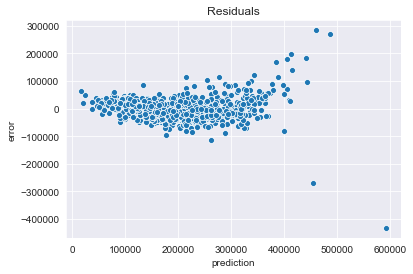

In [6]:
ax = sns.scatterplot(x=prediction, y=errors)
ax.set(xlabel='prediction', ylabel='error', title='Residuals')
plt.show();

4. __Multicolinearity__: does not affect prediction, but affects interpretation of coefficients.

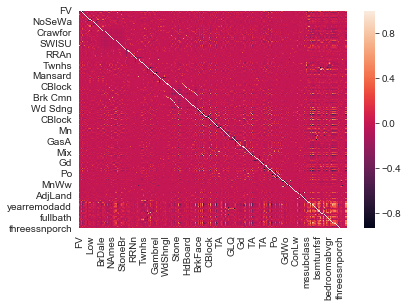

In [7]:
sns.heatmap(new_categories_df.corr());

There are some correlated variables but generally not. should I look at PCA components??

5. __Serial Correlations__: to fix, include ommitted variable

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


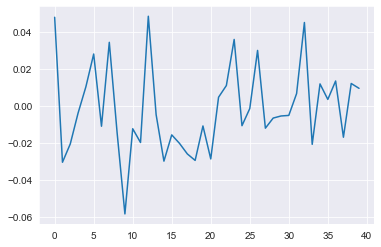

In [8]:
from statsmodels.tsa.stattools import acf
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

6. __Exogeneity__: ___Most Important:___ explanatory variables and errors should be independent. 
    * Common causes are:
        * omitted variables 
        * simultaneous causation between independent variables and the target (solutions to this not covered in bootcamp)
        
Not a requirement to run regression, but non-normality of errors indicates possible ommitted variable and can make significance testing of coefficients invalid.

In [9]:
np.random.normal?

In [17]:
errors

array([ -7819.69882041, -14139.41903807,  -6021.81251482, ...,
        25683.56323933, -13091.18082725, -12743.92082131])

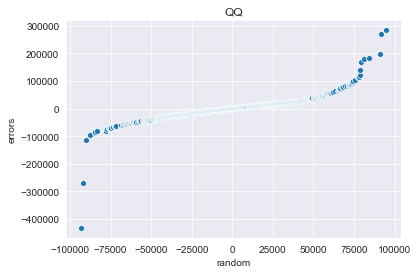

In [11]:
random_numbers = np.random.normal(np.mean(errors), np.std(errors), errors.size)
random_numbers.sort()
ax2 = sns.scatterplot(x=random_numbers, y=np.sort(errors))
ax2.set(xlabel='random', ylabel='errors', title='QQ');

There appear to be a few severe outliers but the bulk of the numbers look ok.